In [1]:
 #%%

# google colab configurations 
# these might change
DATA_GENERATION = '13kwW8C01etWsqTYoE2eeFlD4Ft9YVhrw'
DATA_GENERATION_FILE = 'datageneration.py'

HELPERS = '1zskLM0-ZtEQYVI7zvd2ePqtkTOkJmVIL'
HELPERS_FILE = 'helpers.py'

EXPERIMENT = '1OrYHcTvUXHOrg-86_6oWaN2muDpuzn9a'
EXPERIMENT_FILE = 'experiment.py'

NETWORK = '1iFbCIY8IMaqO4I8mu2J7ie7UDJsLGtRv'
NETWORK_FILE = 'networks.py'

MODEL_CONFIG = '14OF6o1luI8u10Nq96FLBP1M1k-VvQKq-'
MODEL_CONFIG_FILE ='config.json'

HYPER_CONFIG = '1VWlMZnDhE9yhtBi5LrjZoZjTE6nmXsuk'
HYPER_CONFIG_FILE ='hyperparameter_tuning.json'

TUNER = '1I1K9whIpWvzWYjJQjfHLLrE9GXCuRbb1'
TUNER_FILE = 'param_tuner.py'

google_colab = input('Running on Colab?\n')
if google_colab=='yes' : 

    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

    datageneration = drive.CreateFile({'id':DATA_GENERATION})
    datageneration.GetContentFile(DATA_GENERATION_FILE)
    

    helpers = drive.CreateFile({'id':HELPERS})
    helpers.GetContentFile(HELPERS_FILE)

    network = drive.CreateFile({'id':NETWORK})
    network.GetContentFile(NETWORK_FILE)

    experiment = drive.CreateFile({'id':EXPERIMENT})
    experiment.GetContentFile(EXPERIMENT_FILE)

    model_json = drive.CreateFile({'id':MODEL_CONFIG})
    model_json.GetContentFile(MODEL_CONFIG_FILE)

    hyper_json = drive.CreateFile({'id':HYPER_CONFIG})
    hyper_json.GetContentFile(HYPER_CONFIG_FILE)

    param_tuner = drive.CreateFile({'id':TUNER})
    param_tuner.GetContentFile(TUNER_FILE)
    


Running on Colab?
no


In [2]:
# custom imports
from experiment import Experiment
from datageneration import DataGenerator
from helpers import Helper
# torch imports
import torch

# import utils
import json
from datetime import date
import os

# we first get the variables for the configuration file
os.environ["CHECKPOINT_DIR"] = "checkpoints"
os.environ["MODEL_PARAMS"] = "default"

CHECKPOINT_DIR = os.environ['CHECKPOINT_DIR']
MODEL_PARAMS = os.environ['MODEL_PARAMS']

if google_colab=='yes':
    config_director = ''
else:
    config_director = 'configs/'

with open(f'{config_director}config.json') as f:
    file = f.read()
    default_conf = json.loads(file)


In [3]:
# checking whether CUDA is available 
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
    conf['default']['experiment_params']['train_on_gpu'] = True
else: 
    print('No GPU available, training on CPU')

No GPU available, training on CPU


## Generating a dataset

In [15]:
CONFIGURATION='paper_configuration'

In [16]:
datagenerator = DataGenerator(default_conf[CONFIGURATION]['experiment_params']['dimx'],
                              default_conf[CONFIGURATION]['experiment_params']['dimy'],
                              default_conf[CONFIGURATION]['experiment_params']['range_x'],
                              default_conf[CONFIGURATION]['experiment_params']['dim_observation']
                              )
trainloader = Helper.create_loader(datagenerator,
                     default_conf[CONFIGURATION]['data_gen_params']['num_instances_train'],
                     default_conf[CONFIGURATION]['data_gen_params']['noise'],
                     default_conf[CONFIGURATION]['data_gen_params']['length_scale'],
                     default_conf[CONFIGURATION]['data_gen_params']['gamma'],
                     default_conf[CONFIGURATION]['data_gen_params']['batch_size_train'])

valiloader = Helper.create_loader(datagenerator,
                     default_conf[CONFIGURATION]['data_gen_params']['num_instances_vali'],
                     default_conf[CONFIGURATION]['data_gen_params']['noise'],
                     default_conf[CONFIGURATION]['data_gen_params']['length_scale'],
                     default_conf[CONFIGURATION]['data_gen_params']['gamma'],
                     default_conf[CONFIGURATION]['data_gen_params']['batch_size_vali'])

In [17]:
# creating an instance of to orchestrate the training
trainer = Experiment(**default_conf[CONFIGURATION]['experiment_params'])

  0%|          | 0/200000 [00:00<?, ?it/s]

Mean loss at epoch 0 : 1.5846055746078491
True
 Validation loss after 0 equals 1.0898643732070923


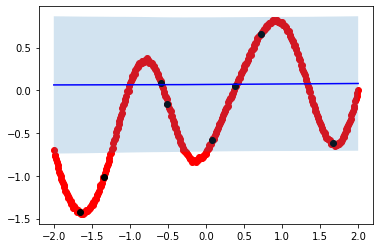

  0%|          | 276/200000 [00:03<44:24, 74.95it/s] 


KeyboardInterrupt: 

In [18]:
model_weights = trainer.run_training(**default_conf[CONFIGURATION]['data_gen_params'], valiloader=None, plotting=True)